In [7]:
import re
import string
import numpy as np
import torch
from torch import Tensor

from nltk.corpus import stopwords
from stop_words import get_stop_words

def get_improved_russian_stopwords():
    """Улучшенный словарь стоп-слов, сохраняющий негативные контексты"""
    stop_words = set(get_stop_words('russian'))
    
    # УДАЛЯЕМ отрицательные слова из стоп-слов (очень важно!)
    negative_words_to_keep = {
        'не', 'нет', 'ни', 'никак', 'никогда', 'нисколько', 'ничуть',
        'отсутствует', 'плохо', 'ужасно', 'кошмар', 'отвратительно',
        'так себе', 'не очень', 'не понравилось', 'не нравится'
    }
    
    # Убираем отрицательные слова из стоп-слов
    stop_words = stop_words - negative_words_to_keep
    
    # Дополнительные стоп-слова для русского языка
    additional_stopwords = {
        'это', 'вот', 'как', 'так', 'и', 'в', 'над', 'к', 'до',
        'на', 'но', 'за', 'то', 'с', 'ли', 'а', 'во', 'от', 'со',
        'для', 'о', 'же', 'ну', 'вы', 'бы', 'что', 'кто', 'он', 'она'
    }
    
    return stop_words.union(additional_stopwords)
stop_words = get_improved_russian_stopwords()

def data_preprocessing(text: str) -> str:
    """preprocessing string: lowercase, removing html-tags, punctuation, 
                            stopwords, digits

    Args:
        text (str): input string for preprocessing

    Returns:
        str: preprocessed string
    """    

    text = text.lower()
    text = re.sub('<.*?>', '', text) # html tags
    text = ''.join([c for c in text if c not in string.punctuation])# Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([word for word in text.split() if not word.isdigit()]) 
    return text

def get_words_by_freq(sorted_words: list[tuple[str, int]], n: int = 10) -> list:
    return list(filter(lambda x: x[1] > n, sorted_words))

def padding(review_int: list, seq_len: int) -> np.array: # type: ignore
    """Make left-sided padding for input list of tokens

    Args:
        review_int (list): input list of tokens
        seq_len (int): max length of sequence, it len(review_int[i]) > seq_len it will be trimmed, else it will be padded by zeros

    Returns:
        np.array: padded sequences
    """    
    features = np.zeros((len(review_int), seq_len), dtype = int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)
            
    return features

def preprocess_single_string(
    input_string: str, 
    seq_len: int, 
    vocab_to_int: dict,
    verbose : bool = False
    ) -> Tensor:
    """Function for all preprocessing steps on a single string

    Args:
        input_string (str): input single string for preprocessing
        seq_len (int): max length of sequence, it len(review_int[i]) > seq_len it will be trimmed, else it will be padded by zeros
        vocab_to_int (dict, optional): word corpus {'word' : int index}. Defaults to vocab_to_int.

    Returns:
        list: preprocessed string
    """    

    preprocessed_string = data_preprocessing(input_string)
    result_list = []
    for word in preprocessed_string.split():
        try: 
            result_list.append(vocab_to_int[word])
        except KeyError as e:
            if verbose:
                print(f'{e}: not in dictionary!')
            pass
    result_padded = padding([result_list], seq_len)[0]

    return Tensor(result_padded)

In [8]:
import pandas as pd

# Загружаем наш файл с отзывами
df = pd.read_json('/home/sokolov/Рабочий стол/ds_bootcamp/ds-phase-2/10-nlp/healthcare_facilities_reviews.jsonl',lines=True)

# Смотрим, что внутри
df.head()

,review_id,category,title,content,sentiment,source_url
0,0,Поликлиники стоматологические,Классный мастер,Огромное спасибо за чудесное удаление двух зуб...,positive,http://www.spr.ru/forum_vyvod.php?id_tema=2727539
1,1,Поликлиники стоматологические,Замечательный врач,Хочу выразить особую благодарность замечательн...,positive,http://www.spr.ru/forum_vyvod.php?id_tema=2302877
2,2,Поликлиники стоматологические,Благодарность работникам рентгена,Добрый вечер! Хотелось бы поблагодарить сотруд...,positive,http://www.spr.ru/forum_vyvod.php?id_tema=2815031
3,3,Поликлиники стоматологические,Доктор Рабинович,Женщины советского образца в регистратуре не и...,negative,http://www.spr.ru/forum_vyvod.php?id_tema=3443161
4,4,Поликлиники стоматологические,Есть кому сказать спасибо,У меня с детства очень плохие зубы (тонкая и х...,positive,http://www.spr.ru/forum_vyvod.php?id_tema=2592430


In [9]:
df = df[['content','sentiment']]

In [12]:
content = df['content'].tolist()
df['content'] = [data_preprocessing(content) for content in content]

In [13]:
df

,content,sentiment
0,огромное чудесное удаление зубов мудрости мгно...,positive
1,хочу выразить особую благодарность замечательн...,positive
2,добрый вечер хотелось поблагодарить сотруднико...,positive
3,женщины советского образца регистратуре не име...,negative
4,детства плохие зубы тонкая хрупкая эмаль криви...,positive
...,...,...
70592,заведение ужасное врачи делят кабинет 2х специ...,negative
70593,не обращайтесь фирму муж проходил анализы врач...,negative
70594,дорогие посетители медицинского центра ооо мед...,positive
70595,регистратуре сидит хамка отношение манера разг...,negative


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

vectorizer = CountVectorizer(max_features=5000)  # берем 5000 самых частых слов

X = vectorizer.fit_transform(df['content'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])

print(f"Получили матрицу: {X.shape}")

Получили матрицу: (70597, 5000)


In [29]:
stop_words = list(stop_words)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words=stop_words)
X = tfidf.fit_transform(df['content'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [32]:
from sklearn.linear_model import LogisticRegression


In [35]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.9381728045325779

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report, 
                           roc_curve, auc, precision_recall_curve)
from sklearn.model_selection import learning_curve

In [40]:
def quick_metrics_visualization(model, X_test, y_test, model_name="Model"):
    """
    Быстрая визуализация основных метрик
    """
    y_pred = model.predict(X_test)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title(f'{model_name} - Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # 2. Метрики в виде bar chart
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    scores = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred)
    ]
    
    bars = ax2.bar(metrics, scores, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    ax2.set_ylim(0, 1)
    ax2.set_title(f'{model_name} - Performance Metrics')
    ax2.set_ylabel('Score')
    
    # Добавляем значения на столбцы
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{score:.3f}', ha='center', va='bottom')
    
    # 3. ROC Curve (если есть вероятности)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        ax3.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC (AUC = {roc_auc:.3f})')
        ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
        ax3.set_xlim([0.0, 1.0])
        ax3.set_ylim([0.0, 1.05])
        ax3.set_xlabel('False Positive Rate')
        ax3.set_ylabel('True Positive Rate')
        ax3.set_title(f'{model_name} - ROC Curve')
        ax3.legend(loc="lower right")
    
    # 4. Error Analysis
    correct = np.sum(y_test == y_pred)
    total = len(y_test)
    error_rate = (total - correct) / total
    
    labels = ['Correct', 'Errors']
    sizes = [correct, total - correct]
    colors = ['lightgreen', 'lightcoral']
    
    ax4.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax4.set_title(f'{model_name} - Correct vs Errors\n(Error Rate: {error_rate:.2%})')
    
    plt.tight_layout()
    plt.show()
    
    # Выводим метрики
    print(f"🎯 {model_name} Results:")
    print(f"   Accuracy:  {scores[0]:.4f}")
    print(f"   Precision: {scores[1]:.4f}")
    print(f"   Recall:    {scores[2]:.4f}")
    print(f"   F1-Score:  {scores[3]:.4f}")
    

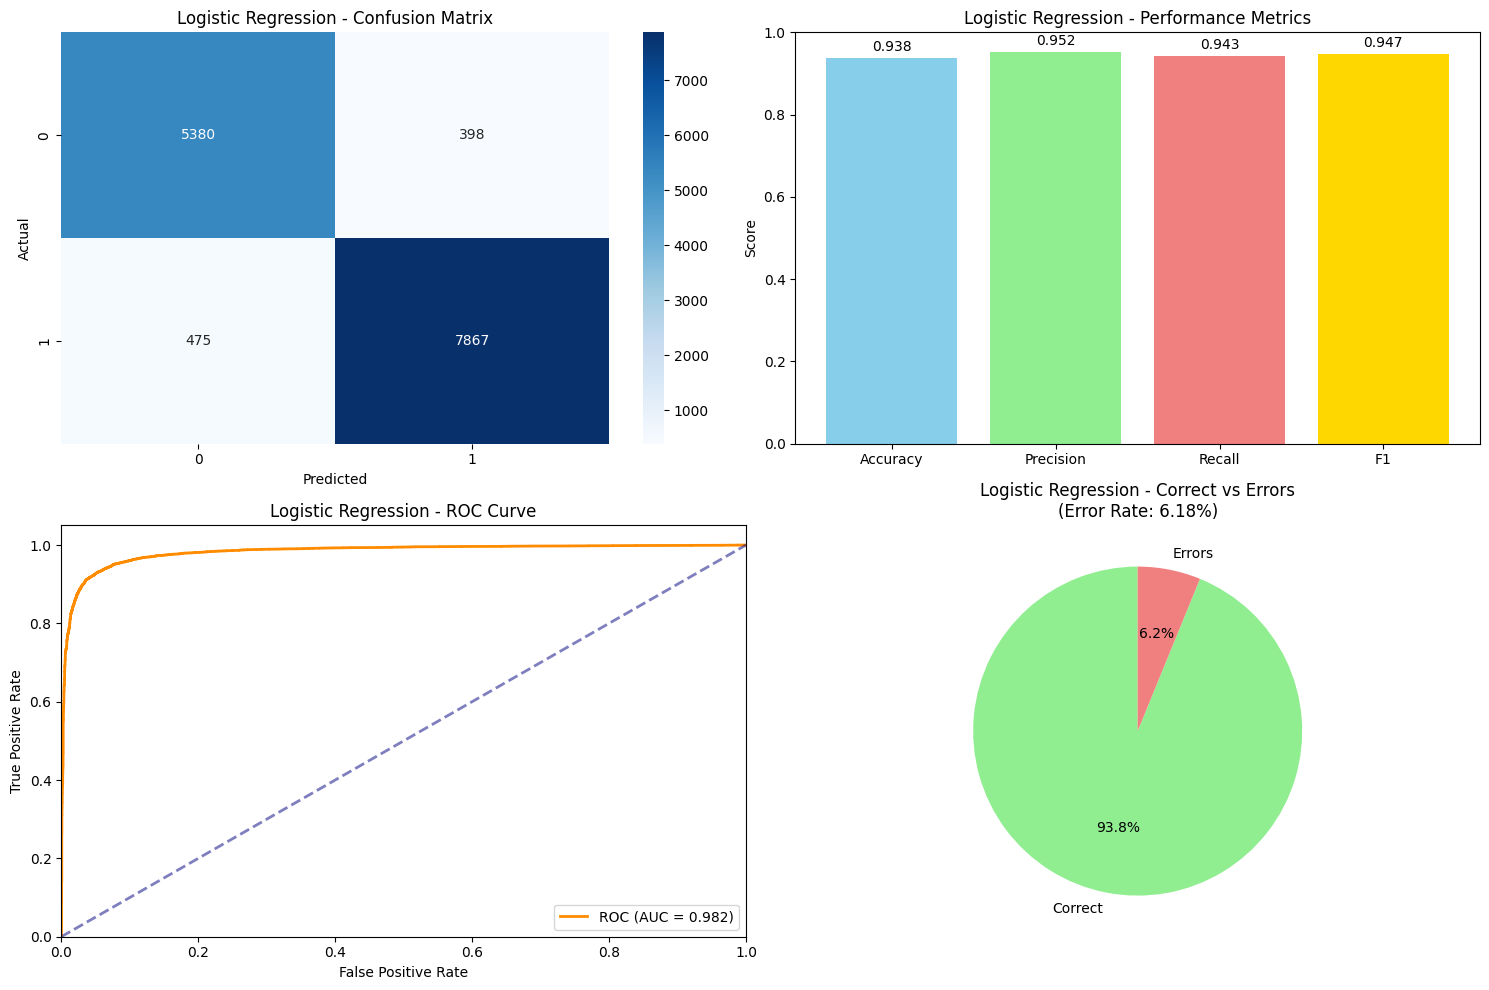

🎯 Logistic Regression Results:
   Accuracy:  0.9382
   Precision: 0.9518
   Recall:    0.9431
   F1-Score:  0.9474


In [42]:

quick_metrics_visualization(
    model=lr_model,
    X_test=X_test,
    y_test=y_test, 
    model_name="Logistic Regression"
)